In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.4)

import torch
import torchvision
from torchvision import models, datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader


from tqdm import tqdm_notebook, trange, tqdm

from sklearn.preprocessing import LabelEncoder
from pathlib import Path
import pickle
from PIL import Image

In [2]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

In [3]:
DATA = ['train', 'val', 'test']
RESCALE_SIZE = 299

In [4]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA:
            print(f'{self.mode} is not correct')
            raise NameError

        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, item):
        base_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        advanced_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.RandomRotation(degrees=45),
            transforms.RandomHorizontalFlip(p=0.7),
            transforms.RandomVerticalFlip(p=0.1),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[item])
        x = self._prepare_sample(x)

        if self.mode == 'train':
            x = advanced_transform(x)
        else:
            x = np.array(x/255, dtype='float32')
            x = base_transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[item]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):

        H = image.size[1]

        W = image.size[0]

        if H>W:
            image = transforms.functional.pad(image,padding=[round(abs(H-W)/2),0])

        else:
            image = transforms.functional.pad(image,padding=[0,round(abs(H-W)/2)])

        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [5]:
TRAIN_DIR = Path('Simpsons/train/simpsons_dataset')
TEST_DIR = Path('Simpsons/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [6]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

train_labels = [path.parent.name for path in train_files]
val_labels = [path.parent.name for path in val_files]

In [7]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i] = dct_simpsons.setdefault(label_i, []) + [path_i]

    return dct_simpsons

In [8]:
dct_path_train = create_dct_path_labels(train_files, train_labels)
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

In [9]:
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files]

In [10]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(new_train_files, mode='train')
test_dataset = SimpsonsDataset(test_files, mode='test')

In [11]:
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=64, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=64, shuffle=True)
}

In [12]:
dataset_size = {'train': len(train_dataset), 'val': len(val_dataset)}
class_name = np.array(np.unique(train_val_labels))

In [13]:
def train(model, train_loader, criterion, optimizer, exp_lr_schedule):
    model.train(True)
    exp_lr_schedule.step()

    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()

        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * xb.size(0)
        running_corrects += torch.sum(preds==yb.data)
        processed_data += xb.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [14]:
def eval(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(xb)
            loss = criterion(outputs, yb)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * xb.size(0)
        running_corrects += torch.sum(preds==yb.data)
        processed_data += xb.size(0)

    val_loss = running_loss / processed_data
    val_acc = running_corrects.double() / processed_data
    return val_loss, val_acc

In [15]:
def fit(model, train_val_loader, epochs: int, optimizer, criterion, exp_lr_scheduler):
    result = []

    with tqdm(desc='epoch', total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = train(model, train_val_loader['train'], criterion, optimizer, exp_lr_scheduler)
            print('loss', train_loss)

            val_loss, val_acc = eval(model, train_val_loader['val'], criterion)
            result.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(f'\n Epoch {epoch+1}, train_loss {train_loss}  val_loss {val_loss} train_accuracy {train_acc} val_acc {val_acc}')

    return result

In [16]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inp in test_loader:
            inp = inp.to(device)
            model.eval()
            outputs = model(inp).cpu()
            logits.append(outputs)

    probs = F.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [104]:
class SimpsonsNet(nn.Module):
    def __init__(self, num_classes=42):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(8, eps=0.0001)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16, eps=0.0001)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32, eps=0.0001)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64, eps=0.0001)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(96, eps=0.0001)
        )
        self.out = nn.Sequential(
            nn.Linear(2400, num_classes)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [105]:
model = SimpsonsNet()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
info = fit(model, dataloaders, 10, optimizer, criterion, exp_lr_scheduler)

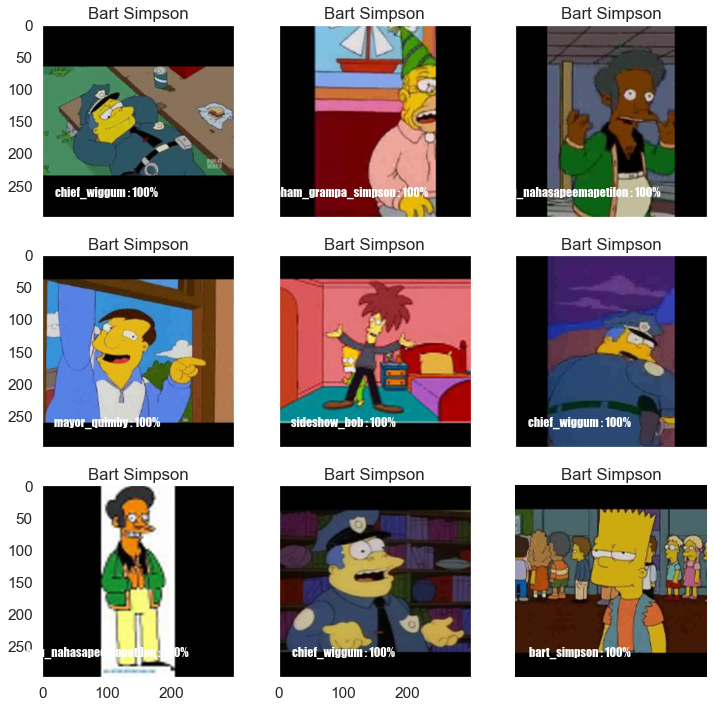

In [29]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


def predict_one_sample(model, inputs):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs


label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))


import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12),
                       sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val = test_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),
                             val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(),
           title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    # fig_x.add_patch(patches.Rectangle((50, 195),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simpsons_inception, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    # predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(100, 260, predicted_text , horizontalalignment='center', fontproperties=font,
               verticalalignment='center',fontsize=12, color='white',fontweight='bold')


In [109]:
torch.save(model.state_dict(), 'ModelAcc79_15.pth')
model.load_state_dict(torch.load('ModelAcc79_15.pth'))

<All keys matched successfully>

In [17]:
simpsons_inception = models.inception_v3(pretrained=True)

In [18]:
simpsons_inception.classifier = nn.Linear(1200, 42)
simpsons_inception = simpsons_inception.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simpsons_inception.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [19]:
simpsons_inception.aux_logits = False
result_inception = fit(simpsons_inception, dataloaders, 10, optimizer, criterion, exp_lr_scheduler)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]C:\Users\Pack\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


loss 1.6481323831178056


epoch:  10%|█         | 1/10 [05:58<53:45, 358.40s/it]


 Epoch 1, train_loss 1.6481323831178056  val_loss 0.266586736082336 train_accuracy 0.6612015389168393 val_acc 0.9314100114635079
loss 0.33959901405795506


epoch:  20%|██        | 2/10 [11:51<47:22, 355.30s/it]


 Epoch 2, train_loss 0.33959901405795506  val_loss 0.1488325906747345 train_accuracy 0.9140574134359278 val_acc 0.9623614826136798
loss 0.2037859027247769


epoch:  30%|███       | 3/10 [18:14<42:55, 367.98s/it]


 Epoch 3, train_loss 0.2037859027247769  val_loss 0.12164589368663857 train_accuracy 0.9482095294465819 val_acc 0.9707680550248375
loss 0.14836500116656184


epoch:  40%|████      | 4/10 [24:01<35:56, 359.48s/it]


 Epoch 4, train_loss 0.14836500116656184  val_loss 0.11252329471198302 train_accuracy 0.962059781000296 val_acc 0.9734428735192969
loss 0.09195494238319182


epoch:  50%|█████     | 5/10 [29:37<29:16, 351.33s/it]


 Epoch 5, train_loss 0.09195494238319182  val_loss 0.09275123122816191 train_accuracy 0.9758508434448061 val_acc 0.9782193351165457
loss 0.07881401098733225


epoch:  60%|██████    | 6/10 [35:14<23:05, 346.43s/it]


 Epoch 6, train_loss 0.07881401098733225  val_loss 0.08929952794460336 train_accuracy 0.9791654335602249 val_acc 0.9793656858998854
loss 0.062195231078882196


epoch:  70%|███████   | 7/10 [40:51<17:10, 343.37s/it]


 Epoch 7, train_loss 0.062195231078882196  val_loss 0.08594643263403222 train_accuracy 0.9836638058597218 val_acc 0.9797478028276653
loss 0.06072619194547985


epoch:  80%|████████  | 8/10 [46:29<11:22, 341.43s/it]


 Epoch 8, train_loss 0.06072619194547985  val_loss 0.08460872233437818 train_accuracy 0.9841373187333531 val_acc 0.9803209782193351
loss 0.05601098518945402


epoch:  90%|█████████ | 9/10 [52:05<05:39, 339.87s/it]


 Epoch 9, train_loss 0.05601098518945402  val_loss 0.08314440753289566 train_accuracy 0.9843740751701687 val_acc 0.9807030951471151
loss 0.05110897555060907


epoch: 100%|██████████| 10/10 [57:43<00:00, 346.34s/it]


 Epoch 10, train_loss 0.05110897555060907  val_loss 0.08320963795881905 train_accuracy 0.9872151524119562 val_acc 0.981085212074895


In [23]:
torch.save(simpsons_inception.state_dict(), 'Simpsons_Inception_98.pth')
simpsons_inception.load_state_dict(torch.load('Simpsons_Inception_98.pth'))

<All keys matched successfully>

In [30]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simpsons_inception, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [31]:
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('.\Prediction_with_inception.csv', index=False)